In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'data/ex2data2.txt'
data = pd.read_csv(data_path, header=None, names = ["x1","x2","y"])
data.head()

,x1,x2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [3]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data['y'] == 0
    pos = data['y'] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos]['x1'], data[pos]['x2'], marker='+', c='orange', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg]['x1'], data[neg]['x2'], c='blue', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

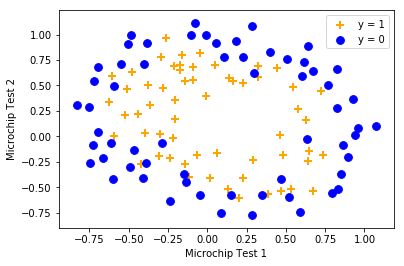

In [4]:
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

In [5]:
n = data.shape[1]-1
x = data[data.columns[0:n]]

y = data[data.columns[n:n+1]]
# convert to np.array
X = x.values
y = y.values

In [6]:
## Feature mapping

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(6)
XX = poly.fit_transform(X)
print(X.shape, XX.shape)

(118, 2) (118, 28)


In [7]:
## Regularized cost function

m = y.shape[0]

def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

def Cost(theta, reg, XX,y):
    h = sigmoid(XX.dot(theta))
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    if np.isnan(J[0]):
        return(np.inf)
    return (J[0])

In [8]:
# testing with reg =1
theta_initial = np.zeros(XX.shape[1])
Cost(theta_initial,1,XX,y)

0.6931471805599454

In [9]:
theta_initial.shape

(28,)

In [10]:
## Partial derivative (with regularization)

def gradientReg(theta, reg, *args):
    
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [11]:
### Optimization

from scipy.optimize import minimize
# reg = 0
res = minimize(Cost, theta_initial, args=(0, XX, y), method=None, jac=gradientReg, options={'maxiter':3000})

In [12]:
res.x.shape

(28,)

In [13]:
res.x

array([   35.10191611,    44.11916367,    69.27189285,  -344.27909796,
        -198.23463107,  -184.22842063,  -295.82043195,  -621.73276992,
        -510.84937859,  -328.31188627,  1094.70043093,  1269.58591485,
        1757.74920108,   900.9379642 ,   436.58887002,   471.12033616,
        1236.23865181,  1822.82037789,  1929.6678079 ,  1131.05332025,
         463.79936004, -1142.11743558, -2020.95914157, -3463.39991601,
       -3484.51078377, -3252.26787475, -1546.00962232,  -510.41275459])

In [14]:
def predict(theta, X, threshold=0.5):
    p = sigmoid(X.dot(theta.T)) >= threshold
    return(p.astype('int'))

In [15]:
accuracy = 100*sum(predict(res.x, XX) == y.ravel())/y.size

In [16]:
accuracy  # for C = reg = lambda = 0 

91.52542372881356

C:\Users\neloy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


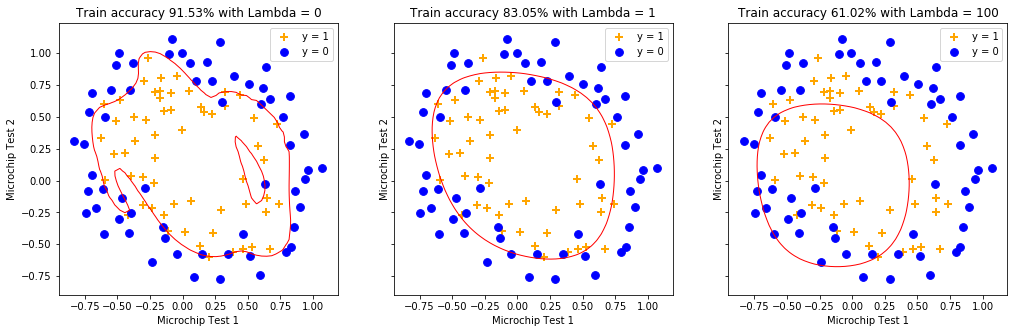

In [17]:
# Effect of lambda

lambda_set = [0,1,100]
fig, axes = plt.subplots(1,len(lambda_set), sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization (overfitting)
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias (underfitting)

x1_min, x1_max = data['x1'].min(), data['x1'].max(),
x2_min, x2_max = data['x2'].min(), data['x2'].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
B0 = np.linspace(x1_min,x1_max)
B1 = np.linspace(x2_min,x2_max)
Z = np.zeros((B0.size,B1.size))

for i, C in enumerate(lambda_set):
    # Optimize costFunctionReg
    res = minimize(Cost, theta_initial, args=(C, XX, y), method=None, jac=gradientReg, options={'maxiter':3000})
    
    def h(x1,x2):
        a=poly.fit_transform(np.c_[x1.ravel(),x2.ravel()])
        return sigmoid(a.dot(res.x))

    # Scatter plot of X,y
    plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
 
    # Contour plot
    for p in range (B0.size):
        for q in range(B1.size):
            Z[p,q] = h(xx1[p,q],xx2[p,q])

    axes.flatten()[i].contour(xx1, xx2, Z, [0.5], linewidths=1, colors='red');   
    
    # Accuracy
    accuracy = 100*sum(predict(res.x, XX) == y.ravel())/y.size 
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))
    